# RNN with formatted text data

In [2]:
import pandas as pd
import os
import numpy as np

In [3]:
df = pd.read_csv('../datasets/post_sub.csv')
df.head()

,post,subreddit
0,Lethargic/Depressed when off meds First I'll g...,adhd
1,Concerta not working on the first day?! Update...,adhd
2,Comorbid anxiety and ADHD-PI Medication Questi...,adhd
3,Fist Day on Concerta 18mg UPDATE! Update!: Tha...,adhd
4,I absolutely hate being so motivated but equal...,adhd


<Axes: title={'center': 'Number posts in each Subreddit'}, xlabel='subreddit'>

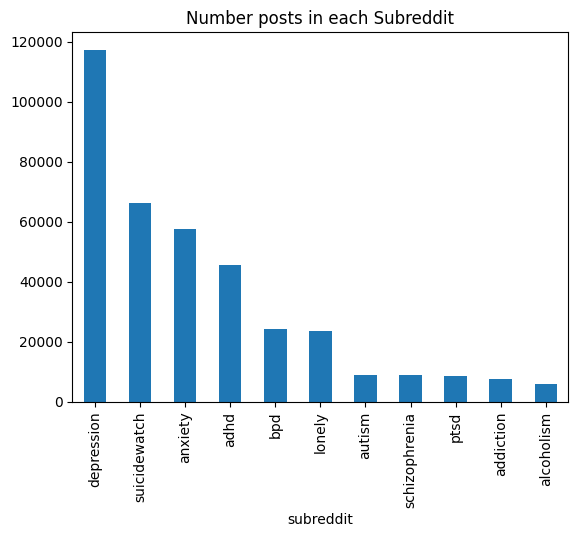

In [4]:
df['subreddit'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number posts in each Subreddit')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import plotly.graph_objs as go
import plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

## Cleaning post data and tokenizing it

In [6]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer


# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text

    # Lemmatize the text
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)

    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [7]:
# Get indexes of rows where subreddit is 'depression'
depression_rows = df[df['subreddit'] == 'depression'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_depression_rows = len(depression_rows)
rows_to_keep = int(total_depression_rows * 0.57)  # 45% of the rows to keep

# Randomly select 45% of the rows to keep
rows_to_keep_indexes = np.random.choice(depression_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = depression_rows.difference(rows_to_keep_indexes)

# Remove 55% of rows with subreddit 'depression'
df.drop(rows_to_remove_indexes, inplace=True)

In [8]:
# Get indexes of rows where subreddit is 'depression'
s_rows = df[df['subreddit'] == 'suicidewatch'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_s_rows = len(s_rows)
rows_to_keep = int(total_s_rows * 0.90)  # 85% of the rows to keep

# Randomly select 45% of the rows to keep
rows_to_keep_indexes = np.random.choice(s_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = s_rows.difference(rows_to_keep_indexes)

# Remove 55% of rows with subreddit 'depression'
df.drop(rows_to_remove_indexes, inplace=True)

In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 283423 unique tokens.


In [10]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (317429, 300)


In [11]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (317429, 11)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [13]:
# print tensorflow version
import tensorflow as tf
print(tf.__version__)

2.15.0


## Training and evaluating the model with WandB

In [13]:
# import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'RNN_scratch_aayush.ipynb'


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTMCell, RNN, Dense, GRUCell, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

wandb.init(project='Reddit_mental_RNN_aayush.ipynb')

# Your data: X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded

# Manual specification of parameters for the first run
params = {
    'units': 300, 'batch': 32
}


In [ ]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 4 or epoch == 6:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_GRU_{}.hd5".format(epoch))

In [21]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(params['units'])) # Using LSTMCell here
model.add(Dense(11, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

epochs = 20
batch_size = params['batch']

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbCallback()])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.7f}\n  Accuracy: {:0.7f}'.format(accr[0], accr[1]))

wandb.log({'test_loss': accr[0], 'test_acc': accr[1]})
wandb.log({'train_loss': history.history['loss'], 'val_loss': history.history['val_loss']})
wandb.log({'train_acc': history.history['accuracy'], 'val_acc': history.history['val_accuracy']})



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 rnn_1 (RNN)                 (None, 150)               113400    
                                                                 
 dense_1 (Dense)             (None, 11)                1661      
                                                                 
Total params: 5115061 (19.51 MB)
Trainable params: 5115061 (19.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
29040/29040 [==============================] - ETA: 0s - loss: 0.5075 

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best)... Done. 0.2s


29040/29040 [==============================] - 3756s 129ms/step - loss: 0.5075 - accuracy: 0.8326 - val_loss: 0.3367 - val_accuracy: 0.8842
Epoch 2/5
29040/29040 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.9056

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best)... Done. 0.1s


29040/29040 [==============================] - 3807s 131ms/step - loss: 0.2748 - accuracy: 0.9056 - val_loss: 0.2619 - val_accuracy: 0.9100
Epoch 3/5
29040/29040 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9267

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best)... Done. 0.2s


29040/29040 [==============================] - 3795s 131ms/step - loss: 0.2114 - accuracy: 0.9267 - val_loss: 0.2378 - val_accuracy: 0.9191
Epoch 4/5
29040/29040 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9382

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best)... Done. 0.1s


29040/29040 [==============================] - 3642s 125ms/step - loss: 0.1778 - accuracy: 0.9382 - val_loss: 0.2292 - val_accuracy: 0.9240
Epoch 5/5
29040/29040 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9451

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/wandb/run-20231119_004047-xalsg7my/files/model-best)... Done. 0.1s


8067/8067 [==============================] - 314s 39ms/step - loss: 0.2270 - accuracy: 0.9262
Test set
  Loss: 0.2269761
  Accuracy: 0.9262423


## Results of the model

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred_argmax)
# # Calculate the relative frequency along the columns (axis=1)
# cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
# print(cm)
# Calculate accuracy per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Create a color map based on the accuracy per class
colors = plt.cm.cividis(class_accuracy)


In [ ]:
# Generating a classification report
print("Classification Report:\n", classification_report(y_test, y_pred_argmax))

In [ ]:
# Plotting the confusion matrix with the defined colormap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='cividis')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix with Color based on Class Accuracy')
plt.show();

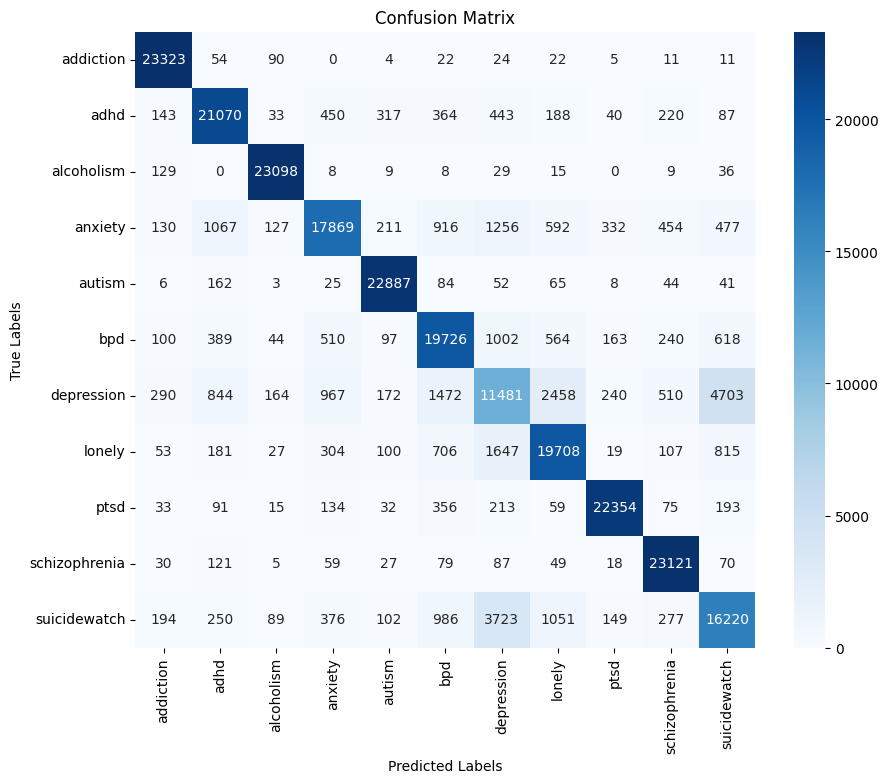

In [ ]:
del model